# Overfitting and Regularization

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [3]:
set_config(display='diagram')

## Settings

In [4]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [5]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

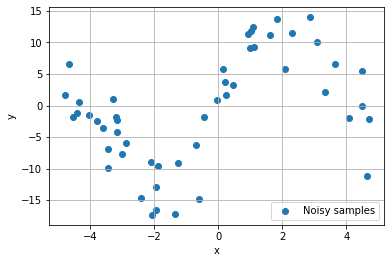

In [6]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

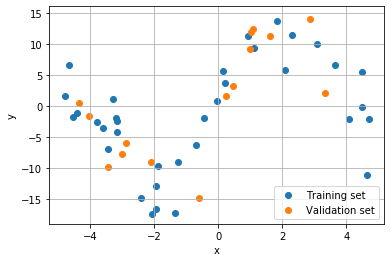

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [8]:
PolynomialFeatures(degree=4).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.,   1.],
       [  1.,   3.,   9.,  27.,  81.],
       [  1.,   4.,  16.,  64., 256.]])

In [9]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression(fit_intercept=False)
    
    # lasso regression
    elif penalty == 'L1':
        regressor = Lasso(fit_intercept=False, alpha=alpha, random_state=SEED, max_iter=50000)        
    
    # ridge regression
    elif penalty == 'L2':
        regressor = Ridge(fit_intercept=False, alpha=alpha, random_state=SEED, max_iter=50000)        
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree)),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures()), ('sca', StandardScaler()),
                ('reg', LinearRegression(fit_intercept=False))])

Pipeline(steps=[('pol', PolynomialFeatures()), ('sca', StandardScaler()),
                ('reg',
                 Lasso(alpha=0.1, fit_intercept=False, max_iter=50000,
                       random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures()), ('sca', StandardScaler()),
                ('reg',
                 Ridge(alpha=0.1, fit_intercept=False, max_iter=50000,
                       random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

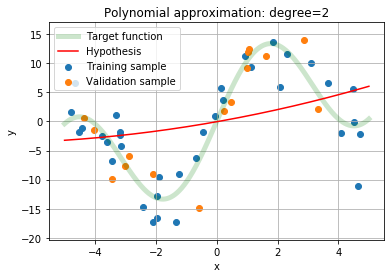

In [10]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

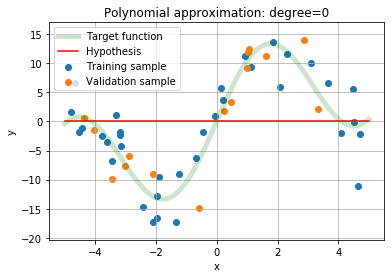

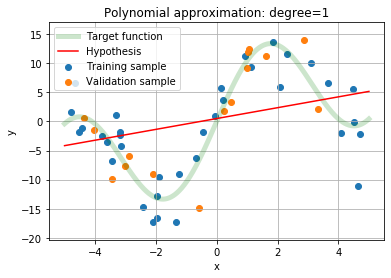

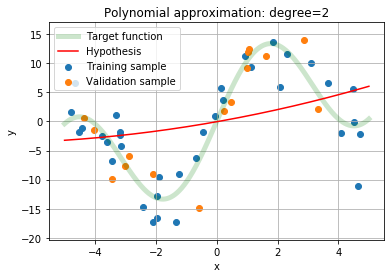

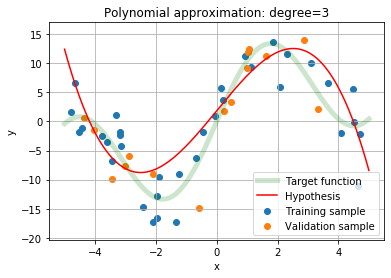

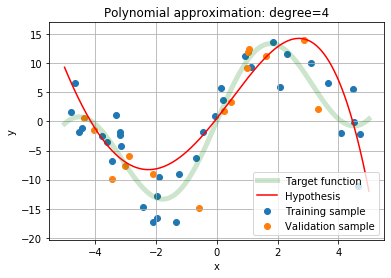

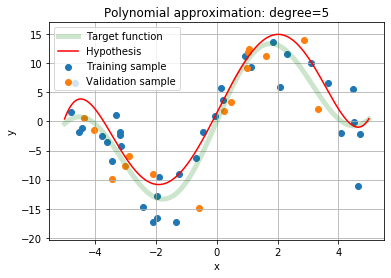

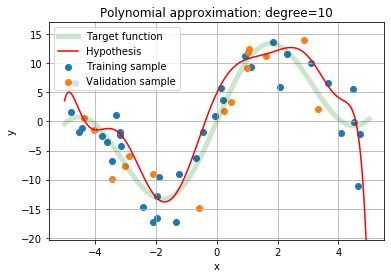

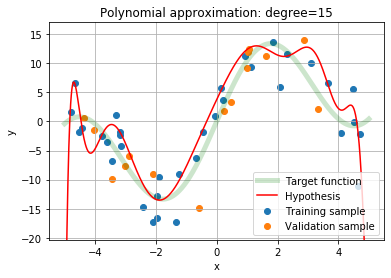

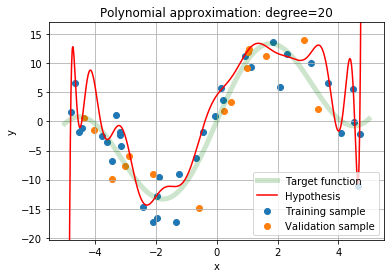

In [11]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

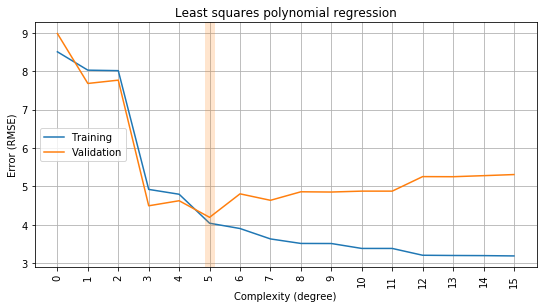

In [12]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [13]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

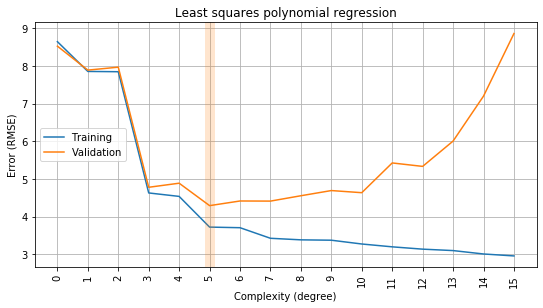

In [14]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [15]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([0.        , 2.81292778]),
 array([0.        , 2.80049884, 0.45166501]),
 array([  0.        ,  30.87315584,   1.48752361, -54.60227825,
         -1.63699842,  26.62792933]),
 array([   0.        ,   33.63850705,  -41.86346242,  -70.48743112,
         278.98853452,   27.48125634, -656.36383501,   59.32988346,
         651.64795186,  -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

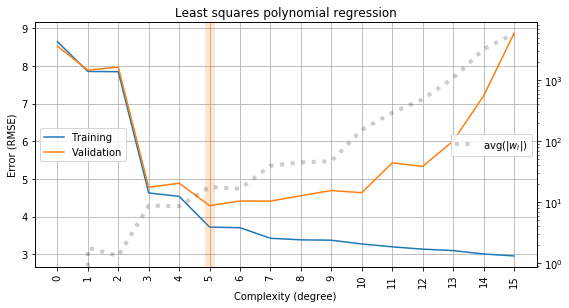

In [16]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

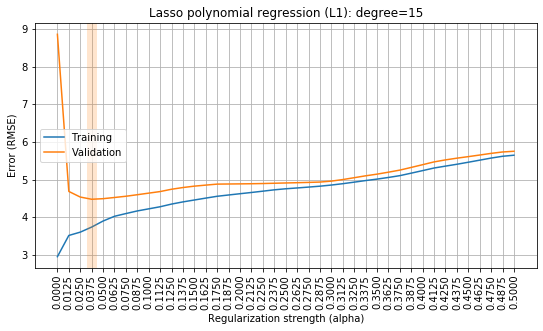

In [17]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

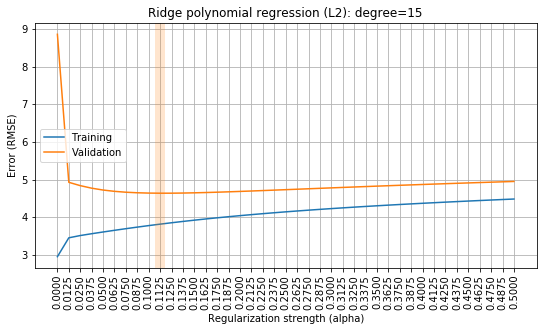

In [18]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

### Excercise 1 - Magnitude (4 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

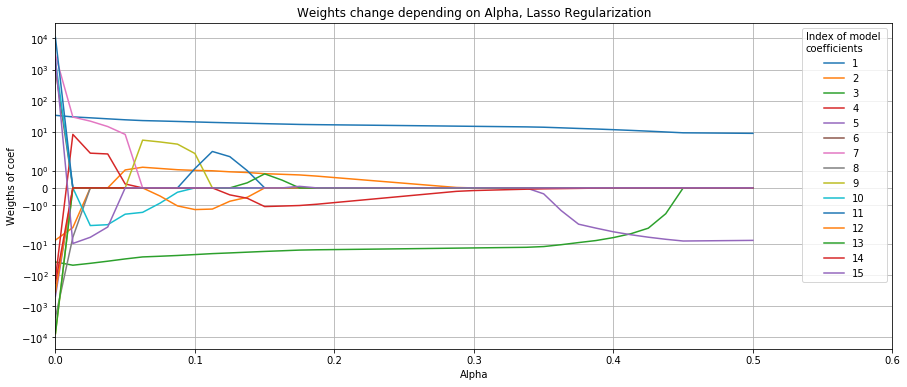

In [19]:
l1_coef = []
for alpha in ALPHAS:
    coef_l1 = list(make_model(degree=15, penalty='L1', alpha=alpha)\
                      .fit(X_train, y_train)['reg'].coef_)[1:]    # start from 1 couse it`s an intercept which =0
    l1_coef.append(coef_l1)
    
plt.figure(figsize=(15,6))
plt.plot(ALPHAS, l1_coef)
plt.xlabel('Alpha')
plt.ylabel('Weigths of coef')
plt.title('Weights change depending on Alpha, Lasso Regularization')
plt.xlim((0, 0.6))
plt.yscale('symlog')
plt.legend([x for x in range(1, len(l1_coef) + 1)], loc='best', title='Index of model \ncoefficients')
plt.grid(True)

#### L2

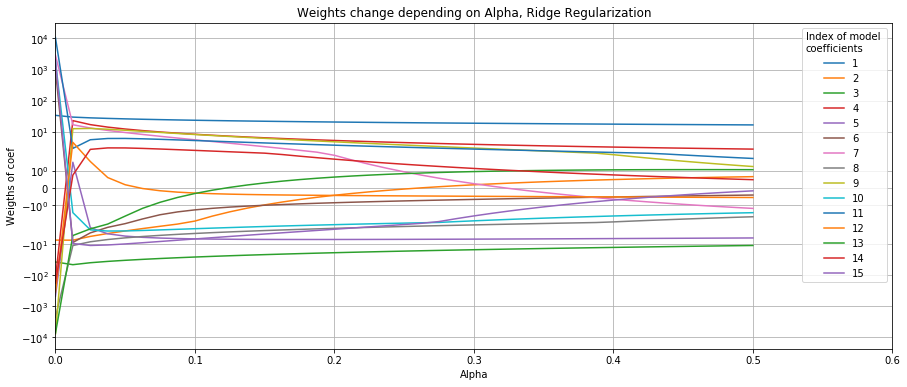

In [20]:
l2_coef = []
for alpha in ALPHAS:
    coef_l2 = list(make_model(degree=15, penalty='L2', alpha=alpha)\
                      .fit(X_train, y_train)['reg'].coef_)[1:]  # start from 1 couse it`s an intercept which =0
    l2_coef.append(coef_l2)
    
plt.figure(figsize=(15,6))
plt.plot(ALPHAS, l2_coef)
plt.xlabel('Alpha')
plt.ylabel('Weigths of coef')
plt.title('Weights change depending on Alpha, Ridge Regularization')
plt.xlim((0, 0.6))
plt.yscale('symlog')
plt.legend([x for x in range(1, len(l1_coef) + 1)], loc='best', title='Index of model \ncoefficients')
plt.grid(True)

#### Summary

As we cas see above, L1 Regularization or Lasso Regularization and L2 Regularization or Ridge Regularization, trying to constraint the weights (model coefficients). Its clear with increasing of alpha, then higher Alpha, then less weigts of coefficients.

## Second way to solve first exercise
Let's suppose, that we want to know what the deviation from zero has coefficients when alpha increases.<br>
Wikipedia says, that In statistics, the standard deviation is a measure of the amount of variation or dispersion of a set of values.A low standard deviation indicates that the values tend to be close to the mean (also called the expected value) of the set, while a high standard deviation indicates that the values are spread out over a wider range.<br>
${\displaystyle s={\sqrt {{\frac {1}{N-1}}\sum _{i=1}^{N}\left(x_{i}-{\bar {x}}\right)^{2}}}.}$<br>

So, if we want to know how far set of elements from zero, we should exchange one value in formula, mean value of set to zero.<br>
${\displaystyle zerodeviation={\sqrt {{\frac {1}{N-1}}\sum _{i=1}^{N}\left(x_{i}-{{0}}\right)^{2}}}.}$<br>
Consequently, a low zero deviation indicates that the values tend to be close to the zero, while a high zero deviation indicates that the values are spread out over a wider range from zero.

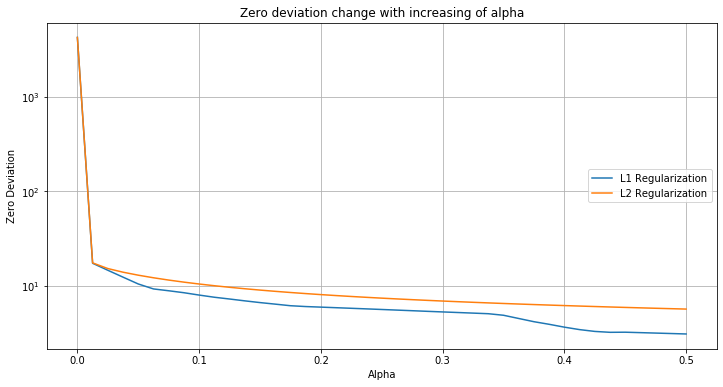

In [113]:
def zero_deviation(elements):
    return np.sqrt(np.sum(np.square(elements)) / (len(elements) - 1))


l1_zero_dev, l2_zero_dev = [], []
for alpha in ALPHAS:
    l1_zero_dev.append(zero_deviation(make_model(degree=15, penalty='L1', alpha=alpha).fit(X_train, y_train)['reg'].coef_[1:]))
    l2_zero_dev.append(zero_deviation(make_model(degree=15, penalty='L2', alpha=alpha).fit(X_train, y_train)['reg'].coef_[1:]))

plt.figure(figsize=(12,6))
plt.plot(ALPHAS, l1_zero_dev, label='L1 Regularization')
plt.plot(ALPHAS, l2_zero_dev, label='L2 Regularization')
plt.legend(loc='right')
plt.title('Zero deviation change with increasing of alpha')
plt.ylabel('Zero Deviation')
plt.xlabel('Alpha')
plt.yscale('symlog')
plt.grid(True)

#### Summary
As we can see, then higher alpha, then more `ZeroDeviation` tend to be close to the zero, therefore coefficients tend to be close
to zero too.

### Excercise 2 - Sparsity (4 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

Text(0, 0.5, 'Number of coefficients')

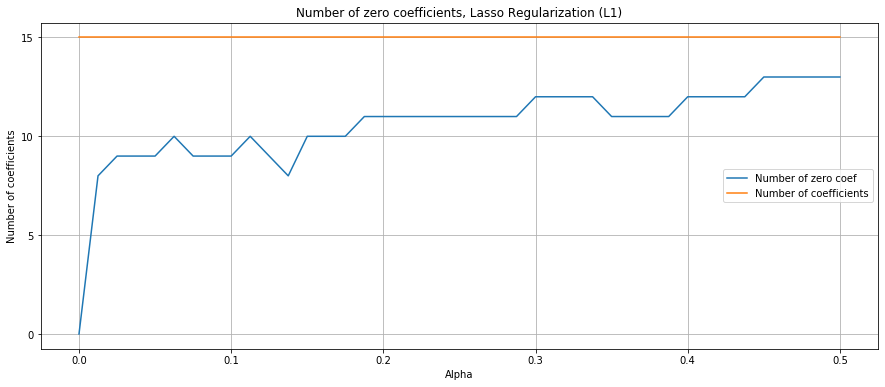

In [109]:
# let`s count number of zero coef for each alpha and then draw it
l1_num_zeroes = []
for alpha in ALPHAS:
    coefl1_zeroes = (make_model(degree=15, penalty='L1', alpha=alpha)\
                     .fit(X_train, y_train)['reg'].coef_ == 0).sum() - 1 # subtract 1 couse it`s an intercept which =0
    l1_num_zeroes.append(coefl1_zeroes)
    
plt.figure(figsize=(15,6))
plt.plot(ALPHAS, l1_num_zeroes, label = 'Number of zero coef')
plt.plot(ALPHAS, [15]*len(ALPHAS), label='Number of coefficients')
plt.yticks(np.arange(0, 16, 5))
plt.grid(True)
plt.legend(loc='center right')
plt.title('Number of zero coefficients, Lasso Regularization (L1)')
plt.xlabel('Alpha'),
plt.ylabel('Number of coefficients')

#### L2

Text(0, 0.5, 'Number of coefficients')

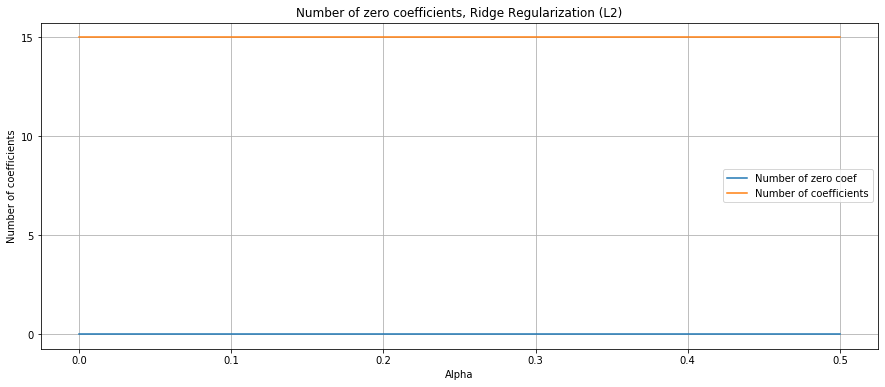

In [110]:
# let`s count number of zero coef for each alpha and then draw it
l2_num_zeroes = []
for alpha in ALPHAS:
    coefl2_zeroes = (make_model(degree=15, penalty='L2', alpha=alpha)\
                     .fit(X_train, y_train)['reg'].coef_ == 0).sum() - 1 # subtract 1 couse it`s an intercept which =0
    l2_num_zeroes.append(coefl2_zeroes)
    
plt.figure(figsize=(15,6))
plt.plot(ALPHAS, l2_num_zeroes, label = 'Number of zero coef')
plt.plot(ALPHAS, [15]*len(ALPHAS), label='Number of coefficients')
plt.yticks(np.arange(0, 16, 5))
plt.grid(True)
plt.legend(loc='center right')
plt.title('Number of zero coefficients, Ridge Regularization (L2)')
plt.xlabel('Alpha'),
plt.ylabel('Number of coefficients')

#### Summary

As we can see above, on the grafics, L1 Regularization is more likely to produce zero coefficients, if alpha increases then
number of zero coef increses too. When alpha=0.5, 13 of 15 coef is equal to 0.

But if we take a look at L2 Regularization we will see, that number of zeroes didn\'t increase. That means, L2 Regularization does not produce zero coefficients, althogh it`s trying to reduce it almost to zeroes.

### Excercise 3 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Why is scaling important? What are the underlying reasons?

### My Thoughts
If we take a look in documentation of (`StandardScaler`) we will find there such explanation :

*For instance many elements used in the objective function of
a learning algorithm (such as the RBF kernel of Support Vector
Machines or the L1 and L2 regularizers of linear models) assume that
all features are centered around 0 and have variance in the same
order. If a feature has a variance that is orders of magnitude larger
that others, it might dominate the objective function and make the
estimator unable to learn from other features correctly as expected.*
<br><br>
Thats means, if we want to be sure that our model is learnd from all features correctly, we have to bring them into equal variance, FeatureScaling helps us with it.

#### To tell long story short, why and when we have to use feature scaling?

The Real World dataset includes features that highly vary in magnitudes, units, and range.<br> Normalization should be executed when the scale of a feature is pointless or misleading and not should Normalise when the scale is meaningful.
Some algorithms which use Euclidean Distance measure are receptive to Magnitudes.<br>Feature scaling also helps to weight all the features equally.
If a feature in the dataset is big in scale compared to others then in algorithms where Euclidean distance is measured this big scaled feature becomes dominating and needs to be normalized.

#### Conclusion
<ul>
    <li> A good reason to perform features scaling is to ensure one feature doesn't dominate others.</li>
    <li>We use Feature Scaling when features in dataset is big in scale compared to others and the algorithm uses Euclidean distance</li>
</ul>
<br><br>
<b>P.S</b>  I didn't whant to copy/paste code from different web pages, thats why i left some links, if you what to check this out. <br>
<a href="https://becominghuman.ai/demystifying-feature-scaling-baff53e9b3fd"> becominghuman.ai </a><br>
<a href="https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html"> scikit-learn.org </a><br>
